# Imports & Functions, must run

In [134]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
'''
Read Data from File
'''
testURL = '../geometries/hBN_water_geometries/supercells_one_water/diff_h/hBN_water_Odown_Hup_8x8x1_supercell_h_2.9907.xyz'
def read_File(URL):
  dataFile = open\
    (URL,'r')
  Lines = dataFile.readlines()
  dataArray = []
  lineNum = 0
  for line in Lines:
    lineNum += 1
    if lineNum <= 2 or len(line.split()) < 4:
      continue
    dataArray.append(line.split())
  return dataArray

'''
Finds the R ij value
'''
def rijVal(rij):
    return np.sum(rij ** 2) ** 0.5

'''
Calculates rij
'''
def distance_Table(data):
  resultTable = []
  for i in range(len(data)):
    el1 = data[i][0]
    thisElPos = np.asarray(data[i][1:], dtype=float)
    for j in range(i, len(data)):
      el2 = data[j][0]
      if el1 == el2 or (el1 + el2 == 'BN' or el1 + el2 == 'OH'): # if same element then skip
        continue
      thatElPos = np.asarray(data[j][1:], dtype=float)
      distance = [el1 + el2, rijVal(thatElPos - thisElPos)]
      # print("this", data[i], ", that", data[j], ", dist = ", distance)
      resultTable.append(distance)
  return resultTable

'''
Calculates Sum of Delta E electrostatic
With q_O = 0 and q_H = +0.52
'''
def delta_e_electrostatic(url):
  data = read_File(url)
  rij = distance_Table(data)

  # partial charge data
  q_O = 0
  q_H = 0.52
  q_B = 0.3
  q_N = 0.3

  result = 0
  for r in rij:
    type = r[0]
    dist = r[1]
    if type == "BO":
      result += q_B * q_O / dist
    elif type == "NO":
      result += q_N * q_O / dist
    elif type == "BH":
      result += q_B * q_H / dist
    elif type == "NH":
      result += q_N * q_H / dist
    else:
      print("Unknown type: ", type)
      result += 0
  return result

def delta_e_vdw(energy, distanceNum):
  distanceNum = str(format(distanceNum, '.4f'))
  fileURL = \
    "../geometries/hBN_water_geometries/supercells_one_water/diff_h/hBN_water_Odown_Hup_8x8x1_supercell_h_" \
      + distanceNum + ".xyz"
  #if distanceNum == 4.5:
  #    fileURL = "../geometries/hBN_water_geometries/supercells_one_water/diff_h/hBN_water_Odown_Hup_8x8x1_supercell_h_4.5000.xyz"
  e_electrostatic = delta_e_electrostatic(fileURL)
  print("Calculating E_electrostatic from: ", distanceNum, ", elctrostatic energy: ", e_electrostatic)
  return energy - e_electrostatic


# Code Testing, Ignore

In [113]:
dEElectro = delta_e_electrostatic(testURL)
print(dEElectro)
testa = delta_e_vdw(0, 2.9907)
print(testa)

12.39871912995158
Calculating E_electrostatic from:  2.9907 , elctrostatic energy:  12.39871912995158
-12.39871912995158


Calculating E_electrostatic from:  2.9907 , elctrostatic energy:  12.39871912995158
Calculating E_electrostatic from:  3.1944 , elctrostatic energy:  12.27930772268507
Calculating E_electrostatic from:  3.3889 , elctrostatic energy:  12.166651407397692
Calculating E_electrostatic from:  3.5926 , elctrostatic energy:  12.050082867542692
Calculating E_electrostatic from:  3.7963 , elctrostatic energy:  11.934952996574266
Calculating E_electrostatic from:  4.5000 , elctrostatic energy:  11.548137036620826


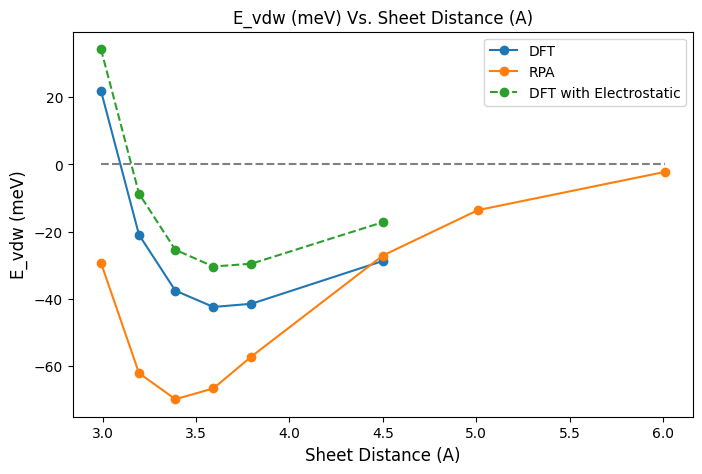

In [114]:
listOfRPAData = [-29.313725490196063, -62.175018155410314, -69.94190268700073, -66.72476397966595, -57.23311546840961, -27.153231663035584, -13.620189, -2.247640]
listOfDFTData = [34.31125758623239, -8.692408367642201, -25.43081842327956, -30.40859912300948, -29.5832775082672, -17.21556188131217]
listOfSheetDistance = [2.9907, 3.1944, 3.3889, 3.5926, 3.7963, 4.5000, 5.0093, 6.0093]

listOfE_vdw = []
for i in range(len(listOfDFTData)):
  listOfE_vdw.append(delta_e_vdw(listOfDFTData[i], listOfSheetDistance[i]))


fig, ax = plt.subplots()
plt.title("E_vdw (meV) Vs. Sheet Distance (A)")
ax.set_xlabel('Sheet Distance (A)',fontsize=12)
ax.set_ylabel('E_vdw (meV)',fontsize=12)
ax.plot(listOfSheetDistance[0:6], listOfE_vdw, "o-",label="DFT")
ax.plot(listOfSheetDistance, listOfRPAData, "o-",label="RPA")
ax.plot(listOfSheetDistance[0:6], listOfDFTData, "o--",label="DFT with Electrostatic")
fig.set_size_inches(8, 5)
fig.set_dpi(100)
plt.hlines(y=0, xmin=2.9907, xmax=6.0093, color="grey", linestyles="--")
plt.legend()
plt.show()

DFT: Epsilon =  42.249056818830326 , Sigma =  3.0552929426799644
RPA: Epsilon =  74.43205261044945 , Sigma =  2.9413449662509232


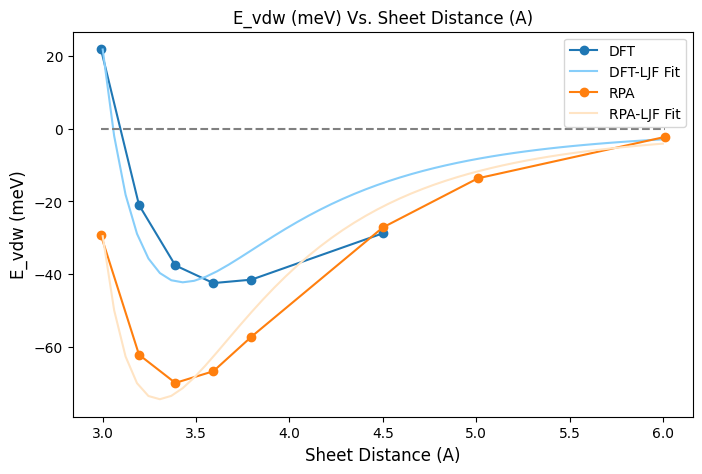

In [159]:
def LJF(r, eps, sig):
  return 4 * eps * (sig / r) ** 6 * ((sig / r) ** 6 - 1)

xData = np.array(listOfSheetDistance[0:6])
yData = np.array(listOfE_vdw)
DFTpopt, DFTpcov = curve_fit(LJF, xData, yData)

RPApopt, RPApcov = curve_fit(LJF, listOfSheetDistance, listOfRPAData)

print("DFT: Epsilon = ", DFTpopt[0], ", Sigma = ", DFTpopt[1])

print("RPA: Epsilon = ", RPApopt[0], ", Sigma = ", RPApopt[1])
fitX = np.linspace(3, 6, 50)

fig, ax = plt.subplots()
plt.title("E_vdw (meV) Vs. Sheet Distance (A)")
ax.set_xlabel('Sheet Distance (A)',fontsize=12)
ax.set_ylabel('E_vdw (meV)',fontsize=12)
ax.plot(listOfSheetDistance[0:6], listOfE_vdw, "o-",label="DFT")
ax.plot(fitX, LJF(fitX, *DFTpopt), color="lightskyblue", label="DFT-LJF Fit")
ax.plot(listOfSheetDistance, listOfRPAData, "o-",label="RPA")
ax.plot(fitX, LJF(fitX, *RPApopt), color="bisque", label="RPA-LJF Fit")
# ax.plot(listOfSheetDistance[0:6], listOfDFTData, "o--",label="DFT with Electrostatic")
fig.set_size_inches(8, 5)
fig.set_dpi(100)
plt.hlines(y=0, xmin=2.9907, xmax=6.0093, color="grey", linestyles="--")
plt.legend()
plt.show()